Következő alkalmazás egy egyszerű mesterséges adathalmazra (make_moons). Először is hozzuk létre mesterségesen az adathalmazt:

In [1]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
X, Y = sklearn.datasets.make_moons(n_samples=1000, random_state=42, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Győződjünk meg róla, hogy az elvárt adathalmazt kapjuk:

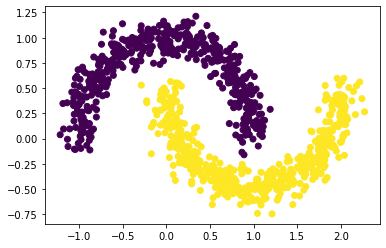

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:, 1], c=Y)

Importáljuk be a PyTorch könyvtár elemeit:

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

Végezzük el a PyTorch adattípushoz való igazítást:

In [4]:
X_train_ = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train_ = torch.from_numpy(y_train).type(torch.FloatTensor)
X_test_ = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_ = torch.from_numpy(y_test).type(torch.FloatTensor)

Definiáljuk hálózatunkat:

In [5]:
class SimpleRegressionElu(nn.Module):
    def __init__(self, input_dim=2, hidden_neurons=5, output_dim=1):
        super(SimpleRegressionElu, self).__init__()
        self.linear = nn.Linear(input_dim, hidden_neurons)
        self.linear_out = nn.Linear(hidden_neurons, output_dim)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)        
        x = self.elu(x)
        x = self.linear_out(x)
        #x = self.linear2(x)
        #x = self.relu(x)
        #x = self.linear3(x)
        return self.sig(x)

Hiperparaméterek hasonló módon kerülnek definiálásra, mint a XOR probléma esetében. Ugyanakkor vegyünk észre valamit: itt már feltétlenül bináris keresztentrópiát kell használnunk hibafüggvényként!

In [6]:
epochs = 500
batch_size = 10
steps = X_train_.shape[0] // batch_size
loss_func = nn.BCELoss()
plt_iter = 10

In [7]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

49 completed, Loss 0.14670555293560028
99 completed, Loss 0.14948292076587677
149 completed, Loss 0.15219655632972717
199 completed, Loss 0.15660381317138672
249 completed, Loss 0.019530747085809708
299 completed, Loss 0.00010883731010835618
349 completed, Loss 6.968005436647218e-06
399 completed, Loss 4.0531236322749464e-07
449 completed, Loss 2.3841860041784457e-08
499 completed, Loss 0.0


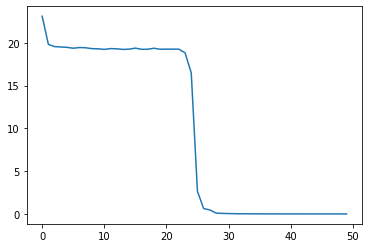

In [8]:
net = SimpleRegressionElu(input_dim=2)

def train(net):
    
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.03)
    weights_init(net)
    all_losses = []
    all_train_accuracy = []
    all_test_accuracy = []
    for epoch in range(epochs):
        current_loss = 0
        all_train_pred = np.zeros((X_train.shape[0], 1))
        for i in range(steps):
            x_var = Variable(X_train_[i:i+batch_size], requires_grad=False)
            y_var = Variable(y_train_[i:i+batch_size], requires_grad=False).reshape(-1, 1)

            optimizer.zero_grad()
            yhat = net(x_var)
            all_train_pred[i:i+batch_size] = yhat.detach().numpy().reshape(batch_size, 1)
            loss = loss_func(yhat, y_var)    
            loss.backward()
            optimizer.step()
            # Training loss
            #
            current_loss += loss
        if epoch %  plt_iter == 0:
            all_losses.append(current_loss)
            # Add test accuracy
            y_hat_class = np.squeeze(np.where(all_train_pred < 0.5, 0, 1), axis=1)
            train_accuracy = (y_train==y_hat_class).sum() / y_hat_class.shape[0]            
            all_train_accuracy.append(train_accuracy)
            x_test_var = Variable(X_test_[i], requires_grad=False)            
            # Test accuracy
            yhat_test = net(x_test_var).detach().numpy()
            yhat_test_class = np.where(yhat_test < 0.5, 0, 1)
            test_accuracy = np.sum(y_test.reshape(-1, 1)==yhat_test_class) / y_test.shape[0]
            all_test_accuracy.append(test_accuracy)            
        if (epoch+1) % 50 == 0:
            print(f"{epoch} completed, Loss {loss}")            
    return all_losses, all_train_accuracy, all_test_accuracy

all_losses, all_train_accuracy, all_test_accuracy = train(net)
plt.plot(all_losses)


Plottoljuk ki a tanítás és tesztelés pontosságát időfüggvényben!

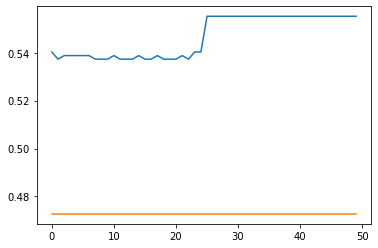

In [9]:
plt.plot(all_train_accuracy)
plt.plot(all_test_accuracy)

Vizualizáció:

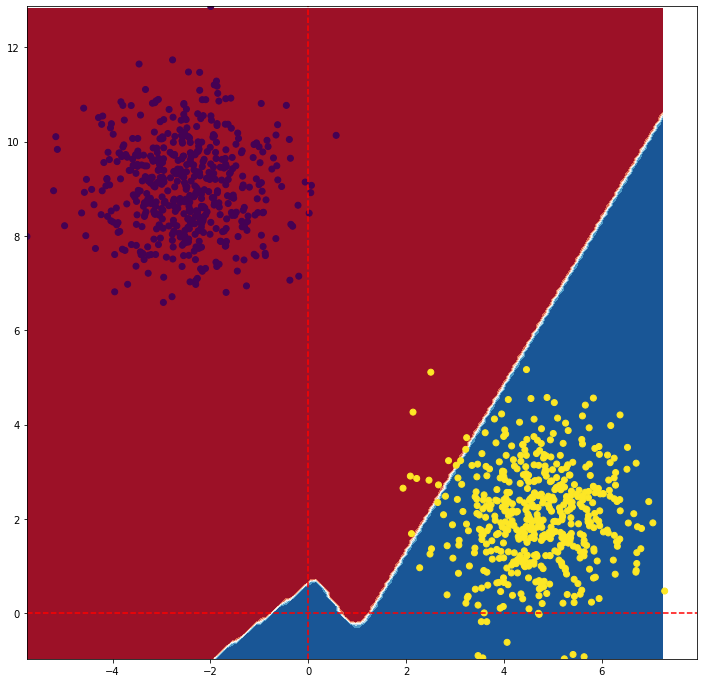

In [21]:
def visualize_results(net, figsize=(12,12)):
    plt.figure(figsize=figsize)
    lt = np.linspace(-3, 3, 100)
    plt.ylim((np.min(X[:,1]),np.max(X[:,1])))
    # Plot contour
    x1grid = np.arange(np.min(X[:,0]), np.max(X[:,0]), 0.1)
    x2grid = np.arange(np.min(X[:,1]), np.max(X[:,1]), 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    #
    yhat = net(torch.from_numpy(grid).type(torch.FloatTensor)).detach().numpy()
    #
    zz = yhat.reshape(xx.shape)
    c = plt.contourf(xx, yy, zz, cmap='RdBu')
    # Show everything
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.scatter(X[:,0], X[:,1], c=Y)

    plt.show()

visualize_results(net)

## ReLU
Látható hogy a példában ELU aktivációs függvényt használtunk. Több forrás megállapította, hogy az ELU pontosabb és kevésbé érzékeny a zajra, mint a ReLU - ami már önmagában szignifikáns előrelépés a szigmoid függvényhez képest.

Lássuk az ELU teljesítményét, ha további perceptronokat adunk hozzá!

Neurons 1
49 completed, Loss 0.19993579387664795
99 completed, Loss 0.19945690035820007
149 completed, Loss 0.19924528896808624
199 completed, Loss 0.19914411008358002
249 completed, Loss 0.1990964114665985
299 completed, Loss 0.19907405972480774
349 completed, Loss 0.19906356930732727
399 completed, Loss 0.19905869662761688
449 completed, Loss 0.199056476354599
499 completed, Loss 0.19905529916286469


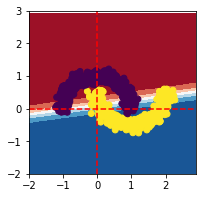

Neurons 2
49 completed, Loss 0.25048893690109253
99 completed, Loss 0.2514970600605011
149 completed, Loss 0.24963685870170593
199 completed, Loss 0.2509213089942932
249 completed, Loss 0.25411179661750793
299 completed, Loss 0.2541733980178833
349 completed, Loss 0.2542226016521454
399 completed, Loss 0.2542429566383362
449 completed, Loss 0.2542489469051361
499 completed, Loss 0.25424903631210327


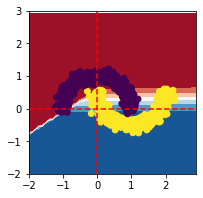

Neurons 4
49 completed, Loss 0.00012703597894869745
99 completed, Loss 3.975664640165633e-06
149 completed, Loss 2.920629924574314e-07
199 completed, Loss 2.3841858265427618e-08
249 completed, Loss 0.0
299 completed, Loss 0.0
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


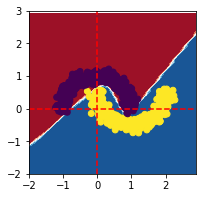

Neurons 5
49 completed, Loss 8.261735638370737e-05
99 completed, Loss 2.8789197585865622e-06
149 completed, Loss 1.7881400538044545e-07
199 completed, Loss 1.1920929132713809e-08
249 completed, Loss 0.0
299 completed, Loss 0.0
349 completed, Loss 0.0
399 completed, Loss 1.1920930020892229e-08
449 completed, Loss 0.0
499 completed, Loss 0.0


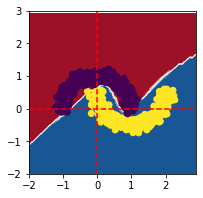

Neurons 7
49 completed, Loss 7.762784662190825e-05
99 completed, Loss 2.461691337884986e-06
149 completed, Loss 1.847745210170615e-07
199 completed, Loss 1.1920930020892229e-08
249 completed, Loss 0.0
299 completed, Loss 0.0
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


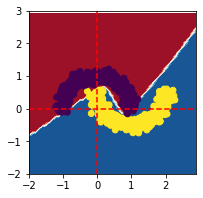

Neurons 10
49 completed, Loss 0.00048688254901207983
99 completed, Loss 7.02155239196145e-06
149 completed, Loss 3.6954912729925127e-07
199 completed, Loss 2.980232594040899e-08
249 completed, Loss 0.0
299 completed, Loss 0.0
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


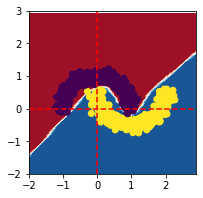

Neurons 15
49 completed, Loss 0.0002063011343125254
99 completed, Loss 1.4896230823069345e-05
149 completed, Loss 1.6927855313042528e-06
199 completed, Loss 2.205374158847917e-07
249 completed, Loss 2.980232949312267e-08
299 completed, Loss 5.9604645663569045e-09
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


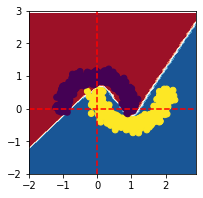

In [14]:
hidden_neurons = [1,2,4,5,7,10,15]
for i in hidden_neurons:
    print(f"Neurons {i}")
    net = SimpleRegressionElu(input_dim=2, hidden_neurons=i)
    train(net)
    visualize_results(net, figsize=(3,3))

Látható, hogy 1 neuron esetében minden változatlan, ugyanaz mintha a XOR problémát oldanánk meg. Viszont 4 neuronnál látható, hogy a probléma már megoldásra kerül.

Ennek a hálónak a ReLU verziója:

In [15]:
class SimpleRegressionRelu(nn.Module):
    def __init__(self, input_dim=2, hidden_neurons=5, output_dim=1):
        super(SimpleRegressionElu, self).__init__()
        self.linear = nn.Linear(input_dim, hidden_neurons)
        self.linear_out = nn.Linear(hidden_neurons, output_dim)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)        
        x = self.relu(x)
        x = self.linear_out(x)
        #x = self.linear2(x)
        #x = self.relu(x)
        #x = self.linear3(x)
        return self.sig(x)

ReLU network
Neurons 1
49 completed, Loss 0.16414162516593933
99 completed, Loss 0.161617249250412
149 completed, Loss 0.1608010232448578
199 completed, Loss 0.16049706935882568
249 completed, Loss 0.1603834331035614
299 completed, Loss 0.16034086048603058
349 completed, Loss 0.16032502055168152
399 completed, Loss 0.16031897068023682
449 completed, Loss 0.1603166162967682
499 completed, Loss 0.16031581163406372


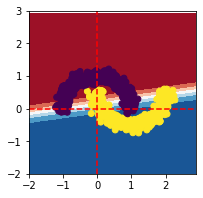

Neurons 2
49 completed, Loss 0.20098531246185303
99 completed, Loss 0.20302143692970276
149 completed, Loss 0.20541417598724365
199 completed, Loss 0.20742949843406677
249 completed, Loss 0.20890755951404572
299 completed, Loss 0.20997421443462372
349 completed, Loss 0.21071311831474304
399 completed, Loss 0.21122582256793976
449 completed, Loss 0.21158675849437714
499 completed, Loss 0.2118428498506546


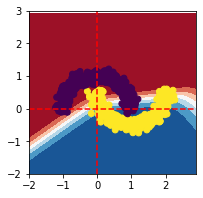

Neurons 4
49 completed, Loss 0.0003082004841417074
99 completed, Loss 2.5531804567435756e-05
149 completed, Loss 3.2067800930235535e-06
199 completed, Loss 4.5299628936845693e-07
249 completed, Loss 6.556513199029723e-08
299 completed, Loss 1.1920930020892229e-08
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


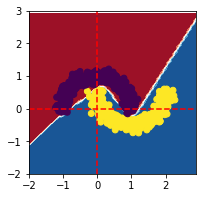

Neurons 5
49 completed, Loss 0.0001721127046039328
99 completed, Loss 1.4449101399804931e-05
149 completed, Loss 1.7762331481208093e-06
199 completed, Loss 2.443793505335634e-07
249 completed, Loss 3.5762791839033525e-08
299 completed, Loss 5.9604645663569045e-09
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


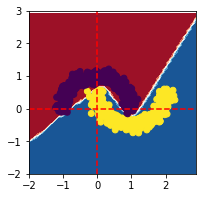

Neurons 7
49 completed, Loss 0.0002629474620334804
99 completed, Loss 2.3003962269285694e-05
149 completed, Loss 2.8312595077295555e-06
199 completed, Loss 3.874309584261937e-07
249 completed, Loss 5.960465898624534e-08
299 completed, Loss 5.9604645663569045e-09
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


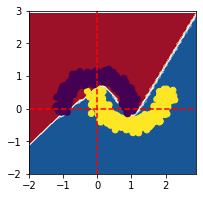

Neurons 10
49 completed, Loss 0.00033392710611224174
99 completed, Loss 3.010459477081895e-05
149 completed, Loss 3.7134363992663566e-06
199 completed, Loss 5.066407311460353e-07
249 completed, Loss 7.74860637875463e-08
299 completed, Loss 1.1920930020892229e-08
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


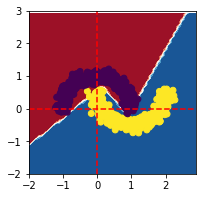

Neurons 15
49 completed, Loss 0.00021098107390571386
99 completed, Loss 1.7936596123035997e-05
149 completed, Loss 2.1994351300236303e-06
199 completed, Loss 2.920631914093974e-07
249 completed, Loss 4.172326129037174e-08
299 completed, Loss 5.9604645663569045e-09
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


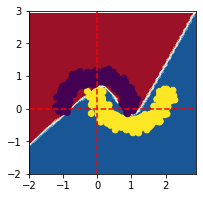

In [16]:
hidden_neurons = [1,2,4,5,7,10,15]
print("ReLU network")
for i in hidden_neurons:
    print(f"Neurons {i}")
    net = SimpleRegressionElu(input_dim=2, hidden_neurons=i)
    train(net)
    visualize_results(net, figsize=(3,3))

## Alkalmazás más adathalamzra

Felmerül a kérdés, hogyan teljesít a neurális háló más adathalmazon. Figyeljük meg ezt egy másik mesterséges adathalmazon, a __make_blobs__ adathalmazon:

In [17]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
X, Y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

49 completed, Loss 0.00017690801178105175
99 completed, Loss 1.1599504432524554e-05
149 completed, Loss 2.348446287214756e-06
199 completed, Loss 3.2782602943370875e-07
249 completed, Loss 3.5762791839033525e-08
299 completed, Loss 0.0
349 completed, Loss 0.0
399 completed, Loss 0.0
449 completed, Loss 0.0
499 completed, Loss 0.0


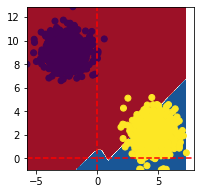

In [22]:
net = SimpleRegressionElu(input_dim=2, hidden_neurons=5)
train(net)
visualize_results(net, figsize=(3,3))